# Mini Project 1


# *Air Quality Analysis  in Australia and Melbourne*
Air pollution reduces the quality of the air. Poor air quality affects human health, animals and the natural environment. Air Quality Index (AQI) is an indicator of how polluted or clean the air is. Government agencies in countries around the world monitor the air quality and report using the Air Quailty Index. The value range of the Air Quality Index used in this analysis is 1 to 5, where 1 = Good, 2 = Fair, 3 = Moderate, 4 = Poor, 5 = Very Poor.

### Pollutants
###### Carbon monoxide
CO is a clear, odorless gas. Smoke and exhaust fumes often contain carbon monoxide. Carbon monoxide forms when materials don’t burn completely. In Victoria, carbon monoxide levels are normally low in the outside air and not harmful to human health. Sources(burning fossil fuels like natural gas, petrol, coal and oil, wood smoke, car and truck exhausts, faulty gas heaters, BBQs, ovens, and cooktops.)
###### Nitrogen dioxide
NO2 is a gas. Breathing it in can irritate your throat and lungs. In Victoria, nitrogen dioxide levels are usually low. Sources (car and truck exhausts, coal-fired power stations industry.)
###### Ozone
O3 is a gas. High in the atmosphere, it protects us from UV radiation. But at ground level, ozone is a pollutant. Ozone can occasionally cause poor air quality during summer. It’s the main pollutant in summer smog. Ozone forms when volatile organic compounds (VOCs) and nitrous oxides react together in the atmosphere. This happens during warm, sunny weather. Sources (car and truck exhausts, bushfire smoke, power stations, industry.)
###### PM10
PM10 are small particles found in dust and smoke. They have a diameter of 10 micrometers (0.01 mm) or smaller. Sources (dust from unsealed roads, smoke from fires, sea salt, car and truck exhausts, industry.)
###### PM2.5 
PM2.5 are small particles usually found in smoke. They have a diameter of 2.5 micrometers (0.0025 mm) or smaller. Sources (smoke from fires, smoke from wood heaters, car and truck exhausts, industry.)
###### Sulfur dioxide
(SO2) is a gas. Sources (Burning materials with a high sulfur content produces sulfur dioxide. In Victoria, the most common sources of sulfur dioxide include: coal-fired power stations, diesel vehicles, oil refineries, shipping.)

### EDA
To Explore real time air pollution data in Australia last six month.

- Current Air pollutant level in Australia vs few other countries in the world.
- Changes in pollutant over the last six months in major cities in Australia.
- Changes in pollutant in Melbourne in last month.
- Pollutant behavior during the day.
- Hypothesis test to analysis air quality in weekday vs weekend.

### Acknowledgements
Data and definitions were taken from Open Weather API (https://openweathermap.org/api) and EPA( Environment Protection Authority Victoria - https://www.epa.vic.gov.au)


##### Import Libraries

In [1]:
import requests
import json
import pandas as pd
import numpy as np
import math
import seaborn as sns
import folium

from datetime import datetime, date, time,timedelta
from folium.plugins import HeatMap, MarkerCluster
from scipy import stats
from matplotlib import pyplot as plt

%matplotlib inline

###  Get data from Open Weather API

In [2]:
api_key_file = open('./api/api_key.txt', 'r')
API_KEY = api_key_file.readline()
api_key_file.close()

# --------------------------------------------------
# Get Coordinates by Country and City
# --------------------------------------------------
def get_coordinates_by_country_city(country, city):
    base_url = "http://api.openweathermap.org/geo/1.0/direct?q="
    url = base_url + city + "," + country + "&limit=1&appid=" + API_KEY
#     print(url)
    response = requests.get(url)
    response_json = response.json()
#     print(response_json)
    return {'country':country, 'city':city, 'lat':response_json[0]['lat'], 'lon':response_json[0]['lon']}

# --------------------------------------------------
# Get Current Air Pollution Data by Country and City
# --------------------------------------------------
def get_current_air_pollution_data_by_country_city(country, city):
    retval = get_coordinates_by_country_city(country, city)
    lat = retval['lat']
    lon = retval['lon']

    base_url = "http://api.openweathermap.org/data/2.5/air_pollution?lat="
    url = base_url + str(lat) + "&lon=" + str(lon) + "&appid=" + API_KEY
#     print(url)
    
    response = requests.get(url)
    response_json = response.json()
#     print(response_json)

    data = response_json['list'][0]

    dt = datetime.fromtimestamp(int(data['dt']))
    aqi = data['main']['aqi']
    co = data['components']['co']
    no = data['components']['no']
    no2 = data['components']['no2']
    o3 = data['components']['o3']
    so2 = data['components']['so2']
    pm2_5 = data['components']['pm2_5']
    pm10 = data['components']['pm10']
    nh3 = data['components']['nh3']

    data_row = {'City':city, 'Country':country, 'Latitude':lat, 'Longitude':lon, 'Date/Time':dt, 'Air Quality Index':aqi, 'CO':co, 'NO':no, 'NO2':no2, 'O3':o3, 'SO2':so2, 'PM2.5':pm2_5, 'PM10':pm10, 'NH3':nh3}

    return data_row

# --------------------------------------------------
# Get Historical Air Pollution Data by Country, City and Duration
# --------------------------------------------------
def get_historical_air_pollution_data_by_country_city(country, city, start, end):
    retval = get_coordinates_by_country_city(country, city)
    lat = retval['lat']
    lon = retval['lon']

    base_url = "http://api.openweathermap.org/data/2.5/air_pollution/history?lat="
    url = base_url + str(lat) + "&lon=" + str(lon) + "&start=" + start + "&end=" + end + "&appid=" + API_KEY
    # print(url)
    
    response = requests.get(url)
    response_json = response.json()
    # print(response_json)
    
    historical_data_list = response_json['list']
    data_row_list = list()
    
    for data in historical_data_list:
        dt = datetime.fromtimestamp(int(data['dt']))
        aqi = data['main']['aqi']
        co = data['components']['co']
        no = data['components']['no']
        no2 = data['components']['no2']
        o3 = data['components']['o3']
        so2 = data['components']['so2']
        pm2_5 = data['components']['pm2_5']
        pm10 = data['components']['pm10']
        nh3 = data['components']['nh3']
        
        data_row = {'City':city, 'Country':country, 'Latitude':lat, 'Longitude':lon, 'Date/Time':dt, 'Air Quality Index':aqi, 'CO':co, 'NO':no, 'NO2':no2, 'O3':o3, 'SO2':so2, 'PM2.5':pm2_5, 'PM10':pm10, 'NH3':nh3}
        data_row_list.append(data_row)

    return data_row_list


In [3]:
# --------------------------------------------------
# Create data frame using Country,City names in the CSV file
# --------------------------------------------------

# --------------------------------------------------
# Australia
# --------------------------------------------------
au_cities_csv_file = pd.read_csv(r'./config/au_capital_cities.csv')
# print(au_cities_csv_file)
CITY_COUNT_MAX = 9

city_names = au_cities_csv_file['Name'].tolist()[:CITY_COUNT_MAX]
country_names = au_cities_csv_file['Country'].tolist()[:CITY_COUNT_MAX]
country_city_names = [list(x) for x in zip(country_names, city_names)]
combined_data_list = list()

start_timestamp="1606780800"
end = datetime.now() - timedelta(days=1)
end_timestamp = str(int(datetime.timestamp(end)))
# print(end_timestamp)

for country, city in country_city_names:
    print("Downloading historical air pollution data [" + city + "] ...")
    row_list = get_historical_air_pollution_data_by_country_city(country, city, start_timestamp, end_timestamp)
    print("Done\n")
    combined_data_list += row_list

# print(combined_data_list)


Done

Done

Done

Done

Done

Done

Done

Done



In [4]:
df = pd.DataFrame(combined_data_list)
display(df)

,City,Country,Latitude,Longitude,Date/Time,Air Quality Index,CO,NO,NO2,O3,SO2,PM2.5,PM10,NH3
0,Canberra,AU,-35.2835,149.1281,2020-12-01 11:00:00,1,185.25,0.21,0.87,63.66,1.18,2.77,6.59,0.55
1,Canberra,AU,-35.2835,149.1281,2020-12-01 12:00:00,1,196.93,0.12,0.54,67.23,1.30,3.33,8.28,0.39
2,Canberra,AU,-35.2835,149.1281,2020-12-01 13:00:00,1,205.28,0.11,0.51,68.67,1.37,3.78,9.56,0.36
3,Canberra,AU,-35.2835,149.1281,2020-12-01 14:00:00,1,213.62,0.10,0.52,71.53,1.45,4.43,11.28,0.36
4,Canberra,AU,-35.2835,149.1281,2020-12-01 15:00:00,1,223.64,0.09,0.50,69.38,1.19,5.57,16.06,0.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47491,Perth,AU,-31.9333,115.8333,2021-08-06 14:00:00,1,223.64,0.82,2.06,50.78,1.59,1.91,4.29,1.95
47492,Perth,AU,-31.9333,115.8333,2021-08-06 15:00:00,1,223.64,0.68,1.84,54.36,1.46,2.13,4.99,1.76
47493,Perth,AU,-31.9333,115.8333,2021-08-06 16:00:00,1,223.64,0.59,1.74,55.79,1.36,2.28,5.70,1.63
47494,Perth,AU,-31.9333,115.8333,2021-08-06 17:00:00,1,236.99,1.44,4.16,53.64,1.74,2.74,6.99,2.76


In [5]:
# --------------------------------------------------
# Create data frame using Country,City names in the CSV file
# --------------------------------------------------

# --------------------------------------------------
# World
# --------------------------------------------------
world_cities_csv_file = pd.read_csv(r'./config/world_cities.csv')
WORLD_CITY_COUNT_MAX = 8

world_city_names = world_cities_csv_file['Name'].tolist()[:WORLD_CITY_COUNT_MAX]
world_country_names = world_cities_csv_file['Country'].tolist()[:WORLD_CITY_COUNT_MAX]
world_country_city_names = [list(x) for x in zip(world_country_names, world_city_names)]
world_combined_data_list = list()

start_timestamp="1606780800"
end = datetime.now() - timedelta(days=1)
end_timestamp = str(int(datetime.timestamp(end)))
# print(end_timestamp)

for world_country, world_city in world_country_city_names:
    print("Downloading historical air pollution data (World) [" + world_city + "] ...")
    row_list = get_historical_air_pollution_data_by_country_city(world_country, world_city, start_timestamp, end_timestamp)
    print("Done\n")
    world_combined_data_list += row_list


df_world = pd.DataFrame(world_combined_data_list)
display(df_world)
# world_city_locations = df_world[['City', 'Country', 'Latitude', 'Longitude']].drop_duplicates('City').values.tolist()

Done

Done

Done

Done

Done

Done

Done

Done



,City,Country,Latitude,Longitude,Date/Time,Air Quality Index,CO,NO,NO2,O3,SO2,PM2.5,PM10,NH3
0,Tokyo,Japan,35.6895,139.6917,2020-12-01 11:00:00,2,487.33,86.73,62.38,2.91,75.34,11.74,18.75,3.23
1,Tokyo,Japan,35.6895,139.6917,2020-12-01 12:00:00,2,433.92,75.10,63.06,6.44,81.06,10.02,17.40,3.52
2,Tokyo,Japan,35.6895,139.6917,2020-12-01 13:00:00,2,387.19,60.80,61.69,12.16,79.16,8.30,15.18,3.36
3,Tokyo,Japan,35.6895,139.6917,2020-12-01 14:00:00,2,347.14,46.94,57.58,18.77,70.57,6.87,12.90,3.01
4,Tokyo,Japan,35.6895,139.6917,2020-12-01 15:00:00,2,303.75,26.60,50.72,29.33,52.93,5.97,10.53,2.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47491,Beijing,China,39.9075,116.3972,2021-08-06 14:00:00,5,1615.52,14.53,120.64,203.13,183.11,404.14,454.35,0.00
47492,Beijing,China,39.9075,116.3972,2021-08-06 15:00:00,5,1575.47,7.38,98.71,314.71,171.66,437.86,490.28,0.00
47493,Beijing,China,39.9075,116.3972,2021-08-06 16:00:00,5,1495.36,3.80,74.71,411.99,150.68,466.13,518.67,0.00
47494,Beijing,China,39.9075,116.3972,2021-08-06 17:00:00,5,1468.66,2.40,65.12,446.32,139.24,475.34,527.07,0.00


##### Describe the dataset and check for null values

In [6]:
df.describe()

,Latitude,Longitude,Air Quality Index,CO,NO,NO2,O3,SO2,PM2.5,PM10,NH3
count,47496.000000,47496.000000,47496.000000,47496.000000,47496.000000,47496.000000,47496.000000,47496.000000,47496.000000,47496.000000,47496.000000
mean,-32.080050,141.366413,1.174478,246.941778,3.369222,8.366857,28.822199,3.796838,4.512552,7.232381,1.136645
std,8.494943,11.789616,0.574635,114.037346,12.859964,10.409288,23.325835,4.849013,6.743336,8.999145,1.843669
min,-42.879400,115.833300,1.000000,130.180000,0.000000,0.040000,0.000000,0.010000,0.500000,0.500000,0.000000
25%,-35.916125,136.660450,1.000000,193.600000,0.010000,1.240000,14.840000,0.527500,1.540000,2.590000,0.210000
50%,-34.400600,146.146350,1.000000,223.640000,0.140000,4.670000,26.110000,2.090000,2.670000,4.770000,0.630000
75%,-30.816950,149.647900,1.000000,260.350000,1.080000,11.650000,38.270000,5.420000,4.730000,8.490000,1.390000
max,-12.461100,153.028100,5.000000,2162.930000,239.610000,200.150000,463.490000,79.160000,134.340000,171.280000,49.650000


In [7]:
df.shape

(47496, 14)

In [8]:
df.isnull().sum()

City                 0
Country              0
Latitude             0
Longitude            0
Date/Time            0
Air Quality Index    0
CO                   0
NO                   0
NO2                  0
O3                   0
SO2                  0
PM2.5                0
PM10                 0
NH3                  0
dtype: int64

In [9]:
# Check for zero values

In [10]:
df.isin([0]).sum()

City                    0
Country                 0
Latitude                0
Longitude               0
Date/Time               0
Air Quality Index       0
CO                      0
NO                   8010
NO2                     0
O3                   1090
SO2                     0
PM2.5                   0
PM10                    0
NH3                  2018
dtype: int64

In [11]:
# Replace zero value with mean

In [12]:
df['NO'] = df['NO'].replace(0, df.NO.mean())
df['O3'] = df['O3'].replace(0, df.O3.mean())
df['NH3'] = df['NH3'].replace(0, df.NH3.mean())

In [13]:
df.isin([0]).sum()

City                 0
Country              0
Latitude             0
Longitude            0
Date/Time            0
Air Quality Index    0
CO                   0
NO                   0
NO2                  0
O3                   0
SO2                  0
PM2.5                0
PM10                 0
NH3                  0
dtype: int64

In [14]:
df.describe()

,Latitude,Longitude,Air Quality Index,CO,NO,NO2,O3,SO2,PM2.5,PM10,NH3
count,47496.000000,47496.000000,47496.000000,47496.000000,47496.000000,47496.000000,47496.000000,47496.000000,47496.000000,47496.000000,47496.000000
mean,-32.080050,141.366413,1.174478,246.941778,3.937427,8.366857,29.483648,3.796838,4.512552,7.232381,1.184939
std,8.494943,11.789616,0.574635,114.037346,12.772680,10.409288,22.903979,4.849013,6.743336,8.999145,1.828083
min,-42.879400,115.833300,1.000000,130.180000,0.010000,0.040000,0.010000,0.010000,0.500000,0.500000,0.010000
25%,-35.916125,136.660450,1.000000,193.600000,0.070000,1.240000,16.270000,0.527500,1.540000,2.590000,0.270000
50%,-34.400600,146.146350,1.000000,223.640000,0.590000,4.670000,27.180000,2.090000,2.670000,4.770000,0.730000
75%,-30.816950,149.647900,1.000000,260.350000,3.369222,11.650000,38.270000,5.420000,4.730000,8.490000,1.390000
max,-12.461100,153.028100,5.000000,2162.930000,239.610000,200.150000,463.490000,79.160000,134.340000,171.280000,49.650000


In [15]:
df.dtypes


City                         object
Country                      object
Latitude                    float64
Longitude                   float64
Date/Time            datetime64[ns]
Air Quality Index             int64
CO                          float64
NO                          float64
NO2                         float64
O3                          float64
SO2                         float64
PM2.5                       float64
PM10                        float64
NH3                         float64
dtype: object

###### Check the correlation between pollutants

<AxesSubplot:>

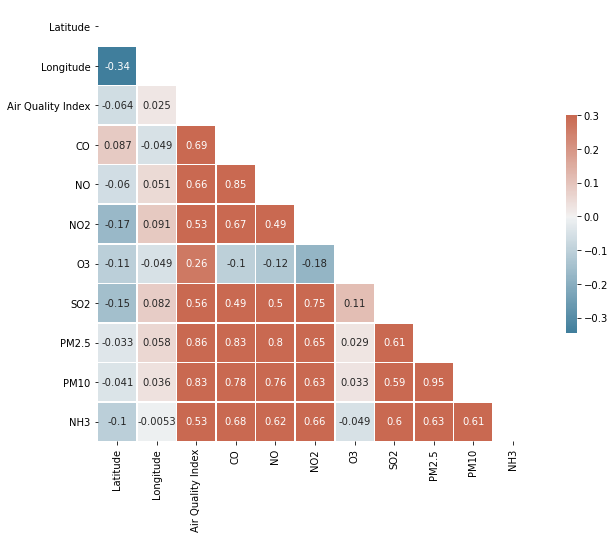

In [16]:
# correlation heatmap
plt.figure(figsize=(12, 8))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
sns.heatmap(df.corr(), annot=True, mask=mask, cmap=cmap,vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [17]:
# Discussion : PM2.5 and PM10 are highly correlated with Air Quality Index and CO. NO and CO are highly correlated.

###### Check Minimum and Maximum value

In [18]:
df.min()

City                            Adelaide
Country                               AU
Latitude                        -42.8794
Longitude                       115.8333
Date/Time            2020-12-01 11:00:00
Air Quality Index                      1
CO                                130.18
NO                                  0.01
NO2                                 0.04
O3                                  0.01
SO2                                 0.01
PM2.5                                0.5
PM10                                 0.5
NH3                                 0.01
dtype: object

In [19]:
df.max()

City                              Sydney
Country                               AU
Latitude                        -12.4611
Longitude                       153.0281
Date/Time            2021-08-06 18:00:00
Air Quality Index                      5
CO                               2162.93
NO                                239.61
NO2                               200.15
O3                                463.49
SO2                                79.16
PM2.5                             134.34
PM10                              171.28
NH3                                49.65
dtype: object

Text(0.5, 1.0, 'Max value of Air Quality Index')

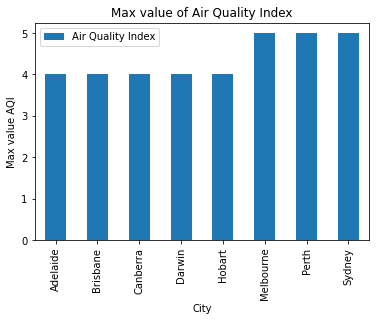

In [20]:
df[['City','Air Quality Index']].groupby(['City']).max().plot.bar()
plt.xlabel('City')
plt.ylabel('Max value AQI')
plt.title("Max value of Air Quality Index")

## EDA 

#### Current Air pollutant level in Australia vs other Countries

###### Load the map

In [21]:
def generateBaseMap(default_location=[-25.478710, 133.912013], default_zoom_start=4):
    '''
    Create a base map
    '''
    base_map = folium.Map(
        location = default_location
        , control_scale = True
        , zoom_start = default_zoom_start
    )
    
    return base_map

In [22]:
def colourgradAQI(value):   # TBD
    if value <= 1:
        hexcolour = 'GreenYellow'
    elif value <= 2:
        hexcolour = 'Green'
    elif value <= 3:
        hexcolour = 'Yellow'
    elif value <= 4:
        hexcolour = 'Orange'
    elif value <= 5:
        hexcolour = 'Red'
    else:
        hexcolour = 'DarkRed'
    return hexcolour

def colourgradCO(value_ug_m3):
    value = value_ug_m3/1000
    if value < 30:
        hexcolour = 'green'
    elif value >= 30 and value < 70:
        hexcolour = 'orange'
    else:
        hexcolour = 'darkred'
    return hexcolour

def colourgradNO(value): # TBD
    if value < 25:
        hexcolour = 'green'
    elif value >= 25 and value < 50:
        hexcolour = 'yellow'
    elif value >= 50 and value < 100:
        hexcolour = 'orange'
    elif value >= 100 and value < 300:
        hexcolour = 'red'
    else:
        hexcolour = 'darkred'
    return hexcolour

def colourgradNO2(value):
    if value < 60:
        hexcolour = 'green'
    elif value >= 60 and value < 120:
        hexcolour = 'yellow'
    elif value >= 120 and value < 180:
        hexcolour = 'orange'
    elif value >= 180 and value < 360:
        hexcolour = 'red'
    else:
        hexcolour = 'darkred'
    return hexcolour

def colourgradO3(value):
    if value < 50:
        hexcolour = 'green'
    elif value >= 50 and value < 100:
        hexcolour = 'yellow'
    elif value >= 100 and value < 150:
        hexcolour = 'orange'
    elif value >= 150 and value < 300:
        hexcolour = 'red'
    else:
        hexcolour = 'darkred'
    return hexcolour

def colourgradSO2(value):
    if value < 100:
        hexcolour = 'green'
    elif value >= 100 and value < 200:
        hexcolour = 'yellow'
    elif value >= 200 and value < 300:
        hexcolour = 'orange'
    elif value >= 300 and value < 600:
        hexcolour = 'red'
    else:
        hexcolour = 'darkred'
    return hexcolour

def colourgradPM25(value):
    if value < 12.5:
        hexcolour = 'green'
    elif value >= 12.5 and value < 25:
        hexcolour = 'yellow'
    elif value >= 25 and value < 50:
        hexcolour = 'orange'
    elif value >= 50 and value < 150:
        hexcolour = 'red'
    else:
        hexcolour = 'darkred'
    return hexcolour

def colourgradPM10(value):
    if value < 40:
        hexcolour = 'green'
    elif value >= 40 and value < 80:
        hexcolour = 'yellow'
    elif value >= 80 and value < 120:
        hexcolour = 'orange'
    elif value >= 120 and value < 300:
        hexcolour = 'red'
    else:
        hexcolour = 'darkred'
    return hexcolour

def colourgradNH3(value): # TBD
    if value < 25:
        hexcolour = 'green'
    elif value >= 25 and value < 50:
        hexcolour = 'yellow'
    elif value >= 50 and value < 100:
        hexcolour = 'orange'
    elif value >= 100 and value < 300:
        hexcolour = 'red'
    else:
        hexcolour = 'darkred'
    return hexcolour

colourgrad_func = {'Air Quality Index':colourgradAQI, 'CO':colourgradCO, 'NO':colourgradNO, 'NO2':colourgradNO2, 'O3':colourgradO3, 'SO2':colourgradSO2, 'PM2.5':colourgradPM25, 'PM10':colourgradPM10, 'NH3':colourgradNH3}


###### Australia Vs Other Countires(Current) - AQI

In [23]:
maps_type = ['Air Quality Index', 'CO', 'NO', 'NO2', 'O3', 'SO2', 'PM2.5', 'PM10', 'NH3']

def display_pollutant_on_map (pollutant):

    map = generateBaseMap(default_location=[0, 24], default_zoom_start=2)

    df_all = df.append(df_world)
    df_all2 = df_all
    all_cities = df_all2[['City', 'Country', 'Latitude', 'Longitude']].drop_duplicates('City').values.tolist()
#     display(df_all)
#     display(all_cities)
    yesterday = datetime.now() - timedelta(days=2)
    yesterday_final=yesterday.strftime('%Y-%m-%d')

#     dfweek1 = df_all[(df_all['Date/Time'].dt.strftime('%Y-%m-%d') == yesterday_final)].groupby('City').mean()
    dfweek1 = df_all[((df_all['Date/Time'].dt.strftime('%Y-%m-%d') >= '2021-01-01') & (df_all['Date/Time'].dt.strftime('%Y-%m-%d') <= '2021-07-01'))].groupby('City').mean()
#     dfweek1 = df_all.groupby('City').mean()
    dfweek2= dfweek1[pollutant].groupby('City').mean()
    dfweek3=pd.DataFrame(dfweek2)

    values=dfweek3[pollutant].values

    for i in range(len(all_cities)):
        city = all_cities[i]
        hex_colour = colourgrad_func[pollutant](values[i])
#         print("City: " + city[0] + " "+ pollutant + ": " + str(values[i]) + ", " + "Color: " + hex_colour)
        # folium.Marker(location=[city[2],city[3]],radius= 10,color= 'red',fill_opacity=0.7).add_to(map)
        folium.CircleMarker(location=[city[2],city[3]],radius= 20,fill_color = hex_colour, color = hex_colour, fill=True, fill_opacity=0.3,opacity=0.5).add_to(map)

    display(map)

# for map in maps_type:
#     display_pollutant_on_map(map)

display_pollutant_on_map('Air Quality Index')

- AQI 1 = 'GreenYellow'
- AQI 2 = 'Green'
- AQI 3 = 'Yellow'
- AQI 4 = 'Orange'
- AQI 5 = 'Red'

Air Quality Index. Possible values: 1, 2, 3, 4, 5. Where 1 = Good, 2 = Fair, 3 = Moderate, 4 = Poor, 5 = Very Poor.

###### Australia Vs Other - NO2 Level

In [24]:
display_pollutant_on_map('NO2')

In [25]:
# 1 = Good, 2 = Fair, 3 = Moderate, 4 = Poor, 5 = Very Poor.

###### Australia Vs Other - COLevel

In [26]:
display_pollutant_on_map('CO')

In [27]:
# 1 = Good, 2 = Fair, 3 = Moderate, 4 = Poor, 5 = Very Poor.

###### Australia Vs Other - SO2 Level

In [28]:
display_pollutant_on_map('SO2')

In [29]:
# 1 = Good, 2 = Fair, 3 = Moderate, 4 = Poor, 5 = Very Poor.

###### Australia Vs Other - PM10 Level

In [30]:
display_pollutant_on_map('PM10')

In [31]:
# 1 = Good, 2 = Fair, 3 = Moderate, 4 = Poor, 5 = Very Poor.

###### Australia Vs Other - PM2.5 Level

In [32]:
display_pollutant_on_map('PM2.5')

In [33]:
# 1 = Good, 2 = Fair, 3 = Moderate, 4 = Poor, 5 = Very Poor.

##### Pollutant  Distribution 

###### Australia

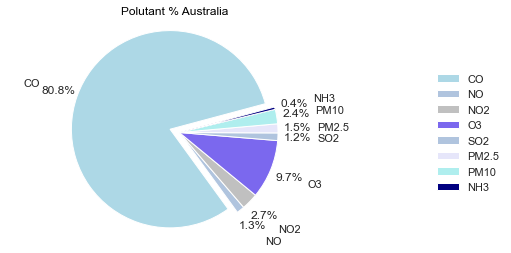

In [34]:
fig, ax = plt.subplots()
# plt.figure(figsize=(10,6))
sns.set_theme(style="darkgrid")
polutant_data=df[['CO', 'NO', 'NO2', 'O3', 'SO2', 'PM2.5', 'PM10', 'NH3']].mean()
polutant_data
my_labels = 'CO', 'NO', 'NO2', 'O3', 'SO2', 'PM2.5', 'PM10', 'NH3'
my_colors = ['lightblue','lightsteelblue','silver','Mediumslateblue','LightSteelBlue','Lavender','PaleTurquoise','Navy']
my_explode = (0.1, 0, 0,0,0,0,0,0)
ax.pie(polutant_data, labels=my_labels, autopct='%1.1f%%', startangle=15, shadow = False, colors=my_colors,pctdistance=1.2,labeldistance=1.4, explode=my_explode)
# plt.title('Polutant % Australia')

ax.set_title("Polutant % Australia")
ax.legend(frameon=False, bbox_to_anchor=(1.5,0.8))
ax.axis('equal')
plt.show()


In [35]:
# The main pollutant is CO which consists of 80.9%.

###### Pollutant By City
<!-- # Canberra
# Sydney
# Darwin
# Brisbane
# Adelaide
# Hobart
# Melbourne
# Perth -->


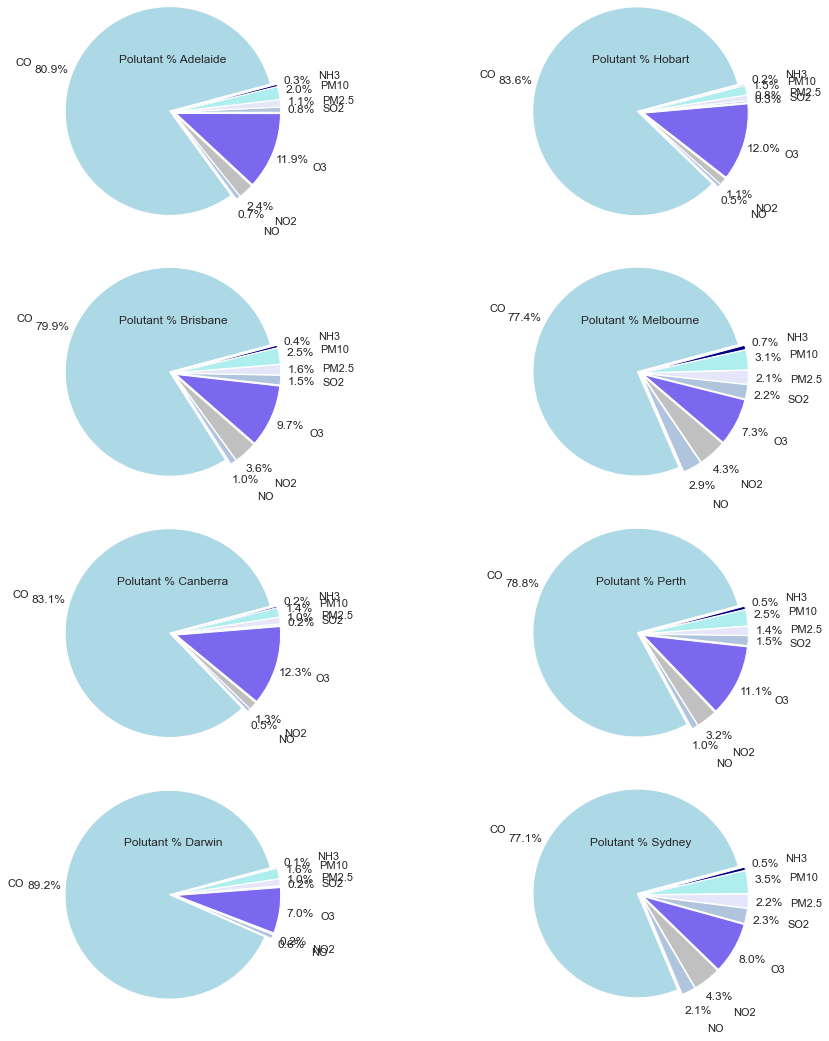

In [36]:
polutant_data_byCity=df[['City','CO', 'NO', 'NO2', 'O3', 'SO2', 'PM2.5', 'PM10', 'NH3']].groupby('City').mean()
 
SUB_PLOT_ROW_COUNT = 4
SUB_PLOT_COL_COUNT = 2
 
fig, axs = plt.subplots(SUB_PLOT_ROW_COUNT, SUB_PLOT_COL_COUNT, figsize=(16, 16))
plt.subplots_adjust(wspace=0.1, hspace=2)


my_labels = 'CO', 'NO', 'NO2', 'O3', 'SO2', 'PM2.5', 'PM10', 'NH3'
my_colors = ['lightblue','lightsteelblue','silver','Mediumslateblue','LightSteelBlue','Lavender','PaleTurquoise','Navy']
my_explode = (0.1, 0.1, 0.1,0.1,0.1,0.1,0.1,0.1)

city_count = len(polutant_data_byCity.index)
i = 0
for col in range(SUB_PLOT_COL_COUNT):
    for row in range(SUB_PLOT_ROW_COUNT):
        city_name = polutant_data_byCity.index[i]
        polutant_data = polutant_data_byCity.iloc[i]

        axs[row, col].pie(polutant_data_byCity.iloc[i], labels=my_labels, autopct='%1.1f%%', startangle=15, shadow = False, colors=my_colors, explode=my_explode, radius=3, pctdistance=1.2,labeldistance=1.4)
        axs[row, col].set_title('Polutant % ' + str(city_name))

        i = i + 1

plt.show()

In [37]:
# Overall all cities have similar pollutant distribution. 

###### AQI Distribution Over Australia

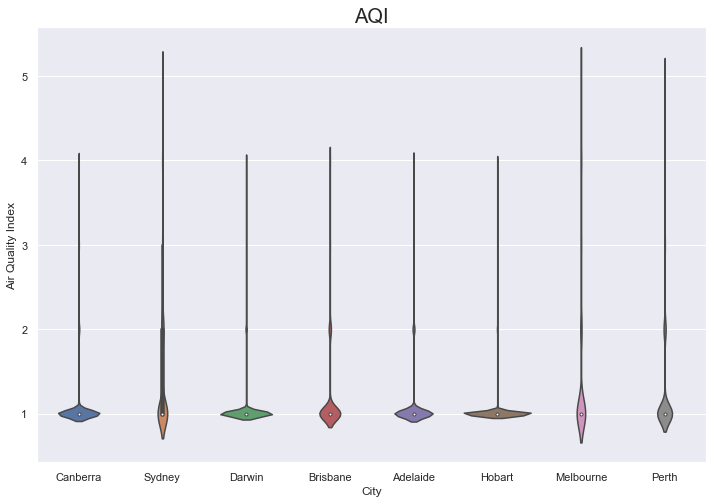

In [38]:
plt.figure(figsize=(12,8))
sns.violinplot(x="City", y="Air Quality Index", data=df).set_title("AQI", fontsize=20)
plt.show()

In [39]:
# Melbourne and Sydney have identical pattern of distribution in AQI following by Peth and Brisbane. Canberra, Darwin,Adelaide and Hobart have similar disrtibution.

###### Pollutant Distribution by City

Text(0.5, 1.0, 'CO')

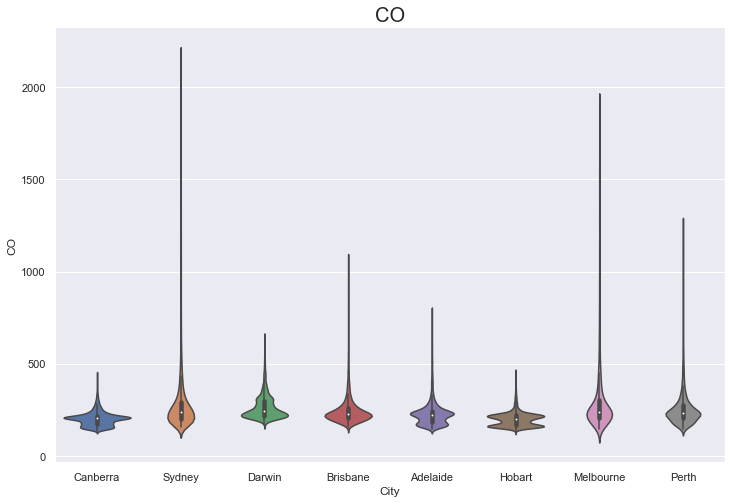

In [40]:
plt.figure(figsize=(12,8))
sns.violinplot(x="City", y="CO", data=df).set_title("CO", fontsize=20)

In [41]:
# Melbourne has the largest spread of CO following by Sydney,Peth and Brisbane. Canberra, Darwin,Adelaide and Hobart have similar disrtibution.

Text(0.5, 1.0, 'O3')

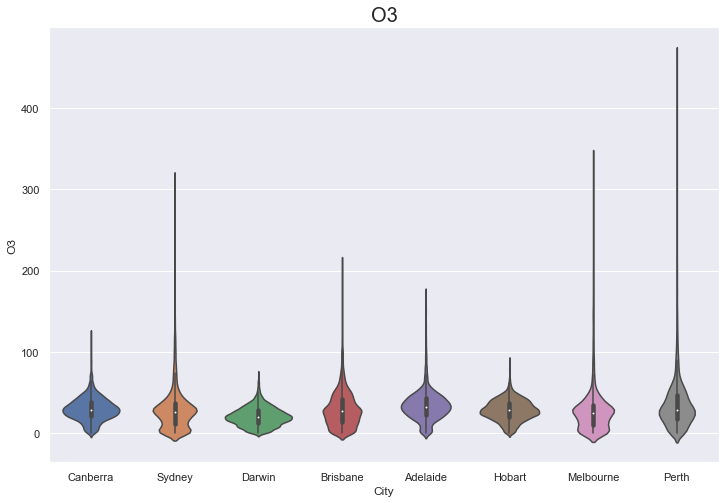

In [42]:
plt.figure(figsize=(12,8))
sns.violinplot(x="City", y="O3", data=df).set_title("O3", fontsize=20)

In [43]:
# Perth has the largest spread of O3 following by Melbourne and Sydney. Brisbane,Canberra, Darwin,Adelaide and Hobart have similar disrtibution.

Text(0.5, 1.0, 'SO2')

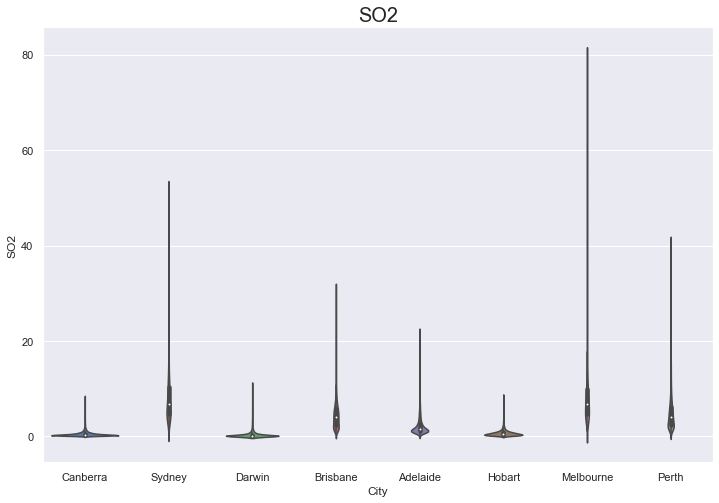

In [44]:
plt.figure(figsize=(12,8))
sns.violinplot(x="City", y="SO2", data=df).set_title("SO2", fontsize=20)

In [45]:
# Melbourne has the largest spread of SO2 following by Sydney,Peth and Brisbane. Canberra, Darwin,Adelaide and Hobart have similar disrtibution.

Text(0.5, 1.0, 'PM2.5')

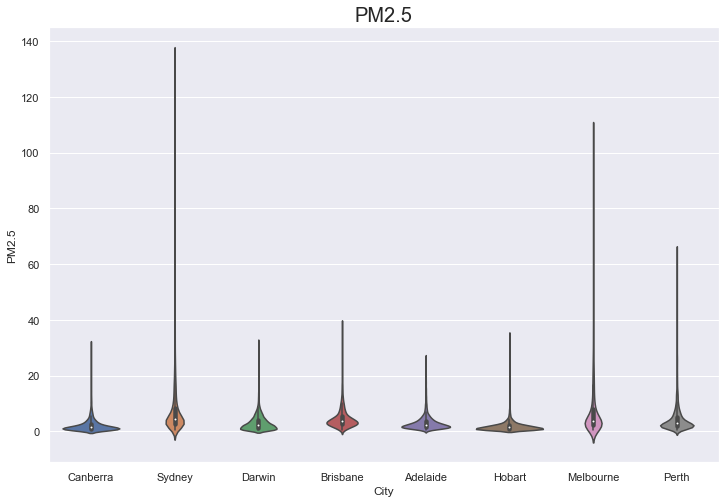

In [46]:
plt.figure(figsize=(12,8))
sns.violinplot(x="City", y="PM2.5", data=df).set_title("PM2.5", fontsize=20)

In [47]:
# Melbourne has the largest spread of PM2.5 following by Sydney,Peth and Brisbane. Canberra, Darwin,Adelaide and Hobart have similar disrtibution.

Text(0.5, 1.0, 'PM10')

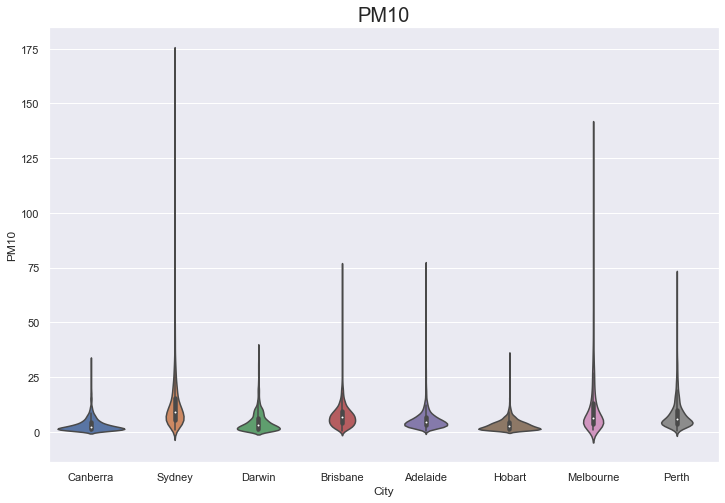

In [48]:
plt.figure(figsize=(12,8))
sns.violinplot(x="City", y="PM10", data=df).set_title("PM10", fontsize=20)

In [49]:
# Melbourne has the largest spread of PM10 following by Sydney,Peth and Adelaide. Canberra,Brisbane, Darwin and Hobart have similar disrtibution.

Text(0.5, 1.0, 'NO')

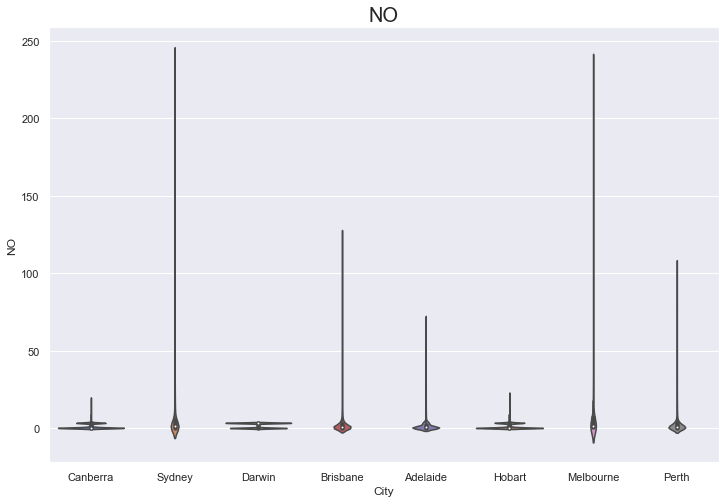

In [50]:
plt.figure(figsize=(12,8))
sns.violinplot(x="City", y="NO", data=df).set_title("NO", fontsize=20)

Text(0.5, 1.0, 'NO2')

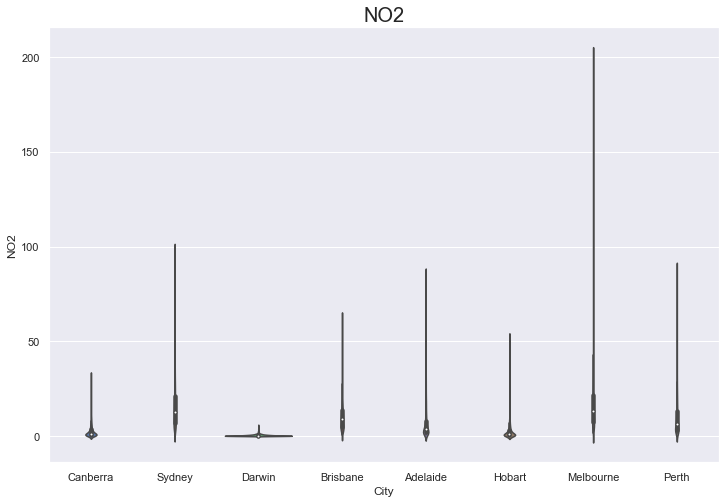

In [51]:
plt.figure(figsize=(12,8))
sns.violinplot(x="City", y="NO2", data=df).set_title("NO2", fontsize=20)

Text(0.5, 1.0, 'NH3')

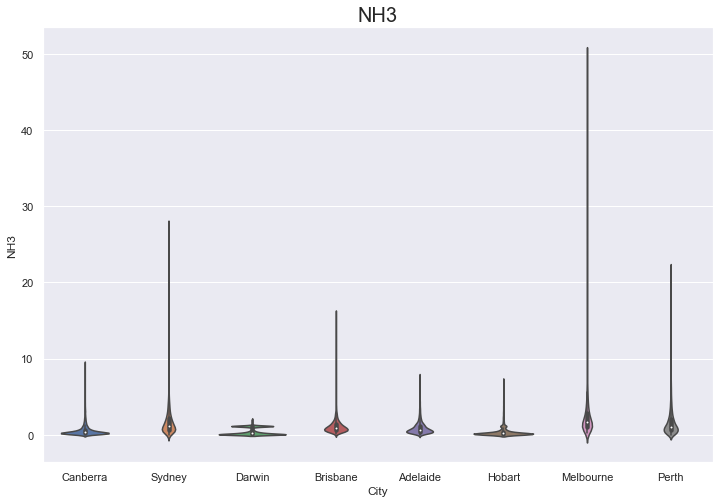

In [52]:
plt.figure(figsize=(12,8))
sns.violinplot(x="City", y="NH3", data=df).set_title("NH3", fontsize=20)

##### Air Quality Index Change over last six month

###### Australia

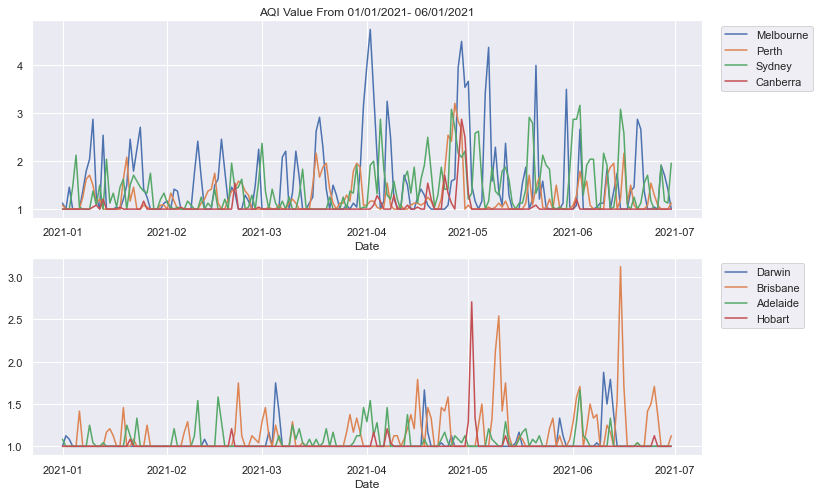

In [53]:
df0 = df[['City', 'Date/Time', 'Air Quality Index','CO', 'NO', 'NO2', 'O3', 'SO2', 'PM2.5', 'PM10', 'NH3']]
df1 = df0[(df0['Date/Time'].dt.strftime('%Y').astype(int) == 2021) &
         (df0['Date/Time'].dt.strftime('%m').astype(int) <= 6)]

df2 = df1.assign(Year = df1['Date/Time'].dt.strftime('%Y'))
df3 = df2.assign(Month = df2['Date/Time'].dt.strftime('%m'))
df4 = df3.assign(Day = df3['Date/Time'].dt.strftime('%d'))
df5 = df4.groupby(['City', 'Year', 'Month', 'Day'],as_index=False).mean()

df5['Date']=pd.to_datetime(df5[['Year', 'Month', 'Day']])
dftime = df5.set_index(['Date'])
dftime_pivot = dftime.pivot_table(index='Date',columns='City',values='Air Quality Index',aggfunc='sum')
# df11=dftime_pivot[['Melbourne']]
fig, ax = plt.subplots(2,1,figsize=(12, 8))
plt.subplots_adjust(hspace=0.2)

sns.lineplot(ax=ax[0], data=dftime_pivot[['Melbourne','Perth','Sydney','Canberra']], dashes = False)
ax[0].legend(bbox_to_anchor=(1.02, 1), loc='upper left')
ax[0].set_title('AQI Value From 01/01/2021- 06/01/2021')
sns.lineplot(ax=ax[1], data=dftime_pivot[['Darwin','Brisbane','Adelaide','Hobart']], dashes = False)
ax[1].legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.show()




In [54]:
# Overall Month of May had a spike of AQI in all cities.Melbourne has reached to 5(AQI value)in month of April and May while other cities are around 3(AQI Value).

###### AQI  value change over last six month

######  By City

In [55]:
df5 = df[(df['Date/Time'].dt.strftime('%Y').astype(int) == 2021) &
         (df['Date/Time'].dt.strftime('%m').astype(int) <= 6)]
df6 = df5.assign(Month = df5['Date/Time'].dt.strftime('%m'))
# display(df6)
df7=df6.groupby(['City','Month'],as_index=False).mean()

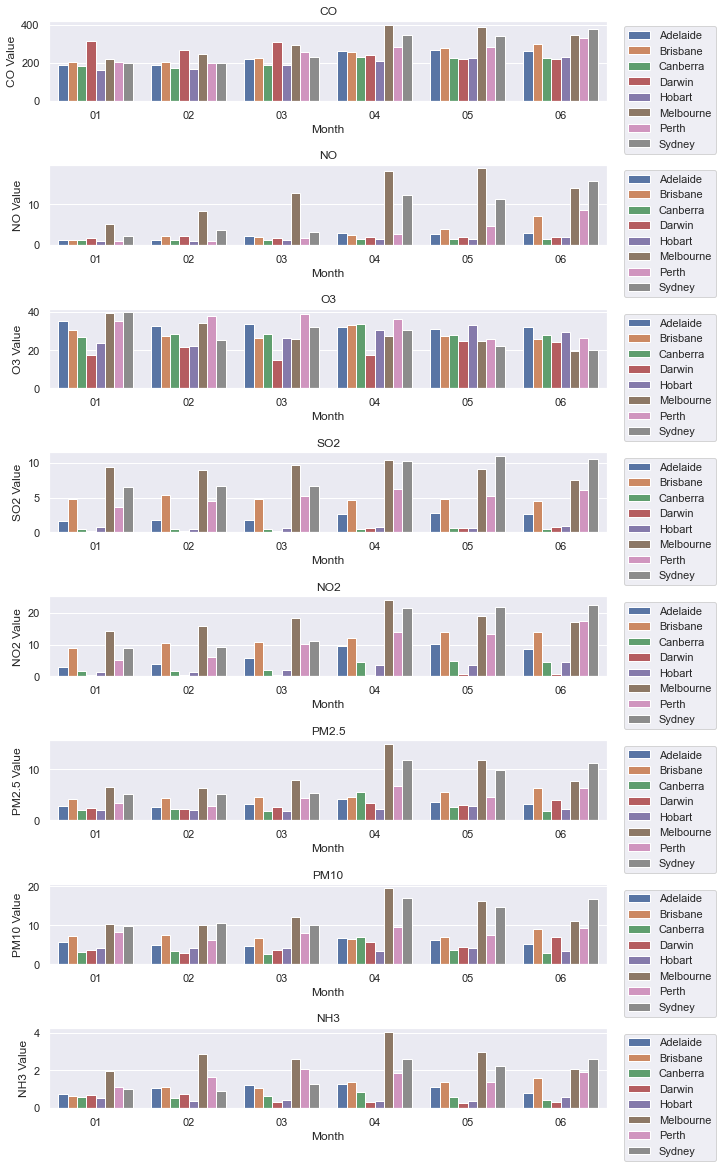

In [56]:
figure, axes = plt.subplots(8, 1,figsize=(10, 20))
plt.subplots_adjust(hspace = 0.8)
sns.set_theme(style="darkgrid")
# dftime.pivot_table(index='Date',columns='City',values='CO').plot()
sns.barplot(data=df7, x="Month", y="CO", hue="City", ax=axes[0]).set(title='CO', xlabel='Month', ylabel='CO Value')
axes[0].legend(bbox_to_anchor=(1.02, 1), loc='upper left')
sns.barplot(data=df7, x="Month", y="NO", hue="City", ax=axes[1]).set(title='NO', xlabel='Month', ylabel='NO Value')
axes[1].legend(bbox_to_anchor=(1.02, 1), loc='upper left')
sns.barplot(data=df7, x="Month", y="O3", hue="City", ax=axes[2]).set(title='O3', xlabel='Month', ylabel='O3 Value')
axes[2].legend(bbox_to_anchor=(1.02, 1), loc='upper left')
sns.barplot(data=df7, x="Month", y="SO2", hue="City", ax=axes[3]).set(title='SO2', xlabel='Month', ylabel='SO2 Value')
axes[3].legend(bbox_to_anchor=(1.02, 1), loc='upper left')
sns.barplot(data=df7, x="Month", y="NO2", hue="City", ax=axes[4]).set(title='NO2', xlabel='Month', ylabel='NO2 Value')
axes[4].legend(bbox_to_anchor=(1.02, 1), loc='upper left')
sns.barplot(data=df7, x="Month", y="PM2.5", hue="City", ax=axes[5]).set(title='PM2.5', xlabel='Month', ylabel='PM2.5 Value')
axes[5].legend(bbox_to_anchor=(1.02, 1), loc='upper left')
sns.barplot(data=df7, x="Month", y="PM10", hue="City", ax=axes[6]).set(title='PM10', xlabel='Month', ylabel='PM10 Value')
axes[6].legend(bbox_to_anchor=(1.02, 1), loc='upper left')
sns.barplot(data=df7, x="Month", y="NH3", hue="City", ax=axes[7]).set(title='NH3', xlabel='Month', ylabel='NH3 Value')
axes[7].legend(bbox_to_anchor=(1.02, 1), loc='upper left')

In [57]:
# Above graphs show the individual pollutant behavior during last six month.

###### AQI change over last month(Month of June) In Melbourne

###### City - Melbourne

In [58]:
df8 = df[(df['City'] == 'Melbourne') &
         (df['Date/Time'].dt.strftime('%Y').astype(int) == 2021) &
         (df['Date/Time'].dt.strftime('%m').astype(int) == 6)]
df9 = df8.assign(Month = df8['Date/Time'].dt.strftime('%m'))
df10 = df9.assign(Date = df9['Date/Time'].dt.strftime('%d'))
df11=df10.groupby(['Month','Date'],as_index=False).mean()


[Text(0.5, 1.0, 'Air Quality Index'),
 Text(0.5, 0, 'Date'),
 Text(0, 0.5, 'Index')]

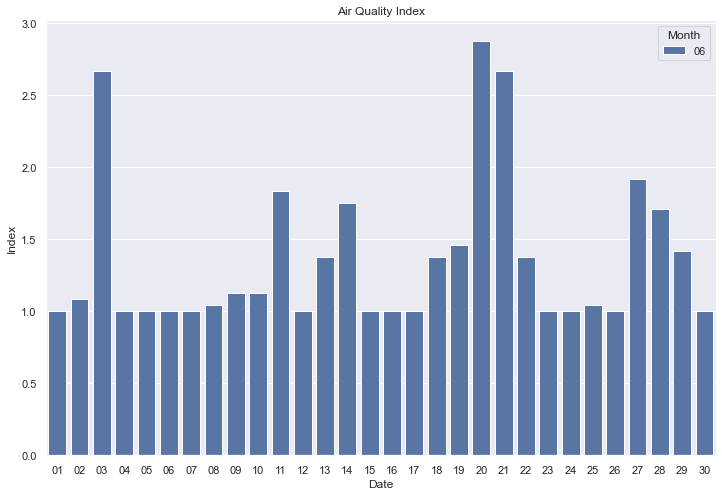

In [59]:
plt.figure(figsize=(12,8))
sns.set_theme(style="darkgrid")
sns.barplot(data=df11, x="Date", y="Air Quality Index", hue="Month").set(title='Air Quality Index', xlabel='Date', ylabel='Index')

In [60]:
# There is a clear indication of low AQI in lockdown period. Which is around first week and second week of month. 

###### Individual Pollutant behavior during last month

[Text(0.5, 1.0, 'NH3'), Text(0.5, 0, 'Date'), Text(0, 0.5, 'NH3 Value')]

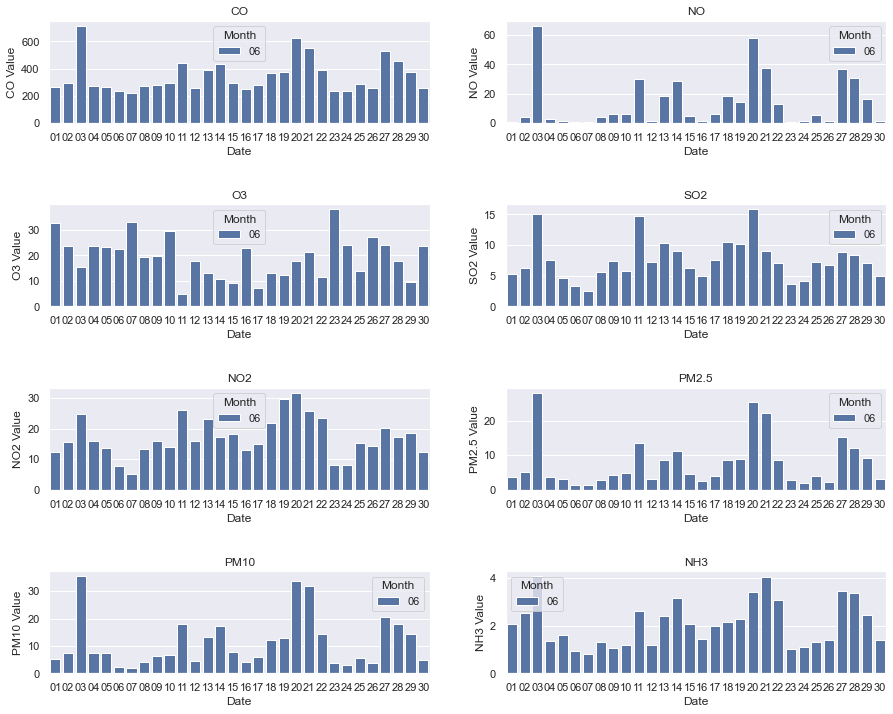

In [61]:
figure, axes = plt.subplots(4, 2,figsize=(15, 12))
plt.subplots_adjust(hspace = 0.8)
sns.set_theme(style="darkgrid")
# sns.lineplot(data=df7, x="Month", y="CO", hue="City", ax=axes[0,0]).set(title='CO', xlabel='Month', ylabel='CO Value')


sns.barplot(data=df11, x="Date", y="CO", hue="Month", ax=axes[0,0]).set(title='CO', xlabel='Date', ylabel='CO Value')
sns.barplot(data=df11, x="Date", y="NO", hue="Month", ax=axes[0,1]).set(title='NO', xlabel='Date', ylabel='NO Value')
sns.barplot(data=df11, x="Date", y="O3", hue="Month", ax=axes[1,0]).set(title='O3', xlabel='Date', ylabel='O3 Value')
sns.barplot(data=df11, x="Date", y="SO2", hue="Month", ax=axes[1,1]).set(title='SO2', xlabel='Date', ylabel='SO2 Value')
sns.barplot(data=df11, x="Date", y="NO2", hue="Month", ax=axes[2,0]).set(title='NO2', xlabel='Date', ylabel='NO2 Value')
sns.barplot(data=df11, x="Date", y="PM2.5", hue="Month", ax=axes[2,1]).set(title='PM2.5', xlabel='Date', ylabel='PM2.5 Value')
sns.barplot(data=df11, x="Date", y="PM10", hue="Month", ax=axes[3,0]).set(title='PM10', xlabel='Date', ylabel='PM10 Value')
sns.barplot(data=df11, x="Date", y="NH3", hue="Month", ax=axes[3,1]).set(title='NH3', xlabel='Date', ylabel='NH3 Value')

In [62]:
# # Above graphs show the individual pollutant behavior during last six month.We can clearly see the correlation between AQI and PM2.5 AND PM10.

##### Pollutant behavior by a given date during 24 hr cycle in Melbourne

In [63]:
yesterday = datetime.now() - timedelta(days=2)
yesterday_final=yesterday.strftime('%Y-%m-%d')

# print(type(yesterday_final))

dfweek = df[(df['City'] == 'Melbourne') &
         (df['Date/Time'].dt.strftime('%Y-%m-%d') == yesterday_final)]
dfweek1 = dfweek.set_index(['Date/Time'])
ts_CO = dfweek1['Air Quality Index']
# ts_CO

- AQI 

<AxesSubplot:xlabel='Date/Time'>

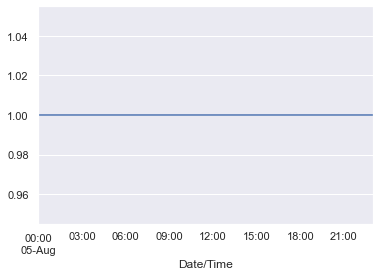

In [64]:
sns.set_theme(style="darkgrid")
ts_AQI = dfweek1['Air Quality Index']
ts_AQI.plot()

[Text(0.5, 1.0, 'PM10'), Text(0.5, 0, 'Time'), Text(0, 0.5, 'PM10 Value')]

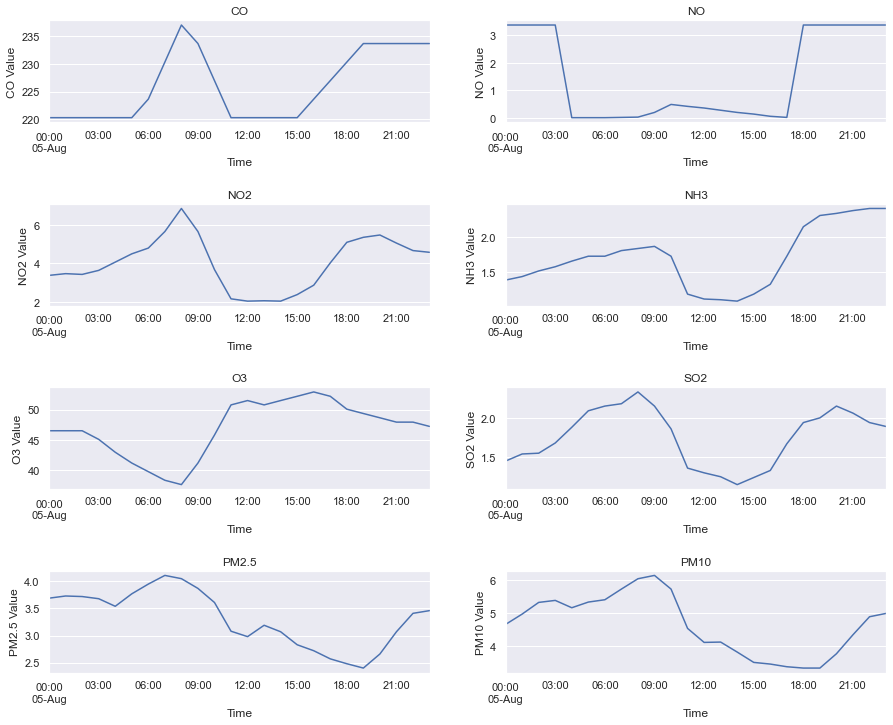

In [65]:
figure, axes = plt.subplots(4, 2,figsize=(15, 12))
sns.set_theme(style="darkgrid")
plt.subplots_adjust(hspace = 0.8)
ts_CO = dfweek1['CO']
ts_NO=dfweek1['NO']
ts_NO2 = dfweek1['NO2']
ts_NH3=dfweek1['NH3']
ts_O3 = dfweek1['O3']
ts_SO2=dfweek1['SO2']
ts_PM25 = dfweek1['PM2.5']
ts_PM10=dfweek1['PM10']
ts_CO.plot(ax=axes[0,0]).set(title='CO', xlabel='Time', ylabel='CO Value')
ts_NO.plot(ax=axes[0,1]).set(title='NO', xlabel='Time', ylabel='NO Value')
ts_NO2.plot(ax=axes[1,0]).set(title='NO2', xlabel='Time', ylabel='NO2 Value')
ts_NH3.plot(ax=axes[1,1]).set(title='NH3', xlabel='Time', ylabel='NH3 Value')
ts_O3.plot(ax=axes[2,0]).set(title='O3', xlabel='Time', ylabel='O3 Value')
ts_SO2.plot(ax=axes[2,1]).set(title='SO2', xlabel='Time', ylabel='SO2 Value')
ts_PM25.plot(ax=axes[3,0]).set(title='PM2.5', xlabel='Time', ylabel='PM2.5 Value')
ts_PM10.plot(ax=axes[3,1]).set(title='PM10', xlabel='Time', ylabel='PM10 Value')

In [66]:
# We can observe high AQI (high pollution) around peak hours. 

##### Hypothesis Testing

Let's assume if `PM2.5` is main factor of defining Air Pollution. Air Pollution increases when the `PM2.5` increases.P.M value  can be increase due to traffic/factory emission.

**ANSWER:**

    H0: There is no difference between mean value of `Weekday PM2.5` & `Weekend`PM2.5
    H1: There is difference between mean value of `Weekday PM2.5` & `Weekend`PM2.5
    


In [67]:
df1 = df[(df['City'] == 'Melbourne') &
         (df['Date/Time'].dt.strftime('%A') != 'Saturday') & (df['Date/Time'].dt.strftime('%A') != 'Sunday')]
# display(df1)
df2 = df[(df['City'] == 'Melbourne') &
         (df['Date/Time'].dt.strftime('%A') == 'Saturday') | (df['Date/Time'].dt.strftime('%A') == 'Sunday')]


In [68]:
# df1 = df[['City', 'CO']]
Weekday_PM=df1[['PM2.5']].sample(100)
Weekend_PM=df2[['PM2.5']].sample(100)

In [69]:
alpha = 0.05

In [70]:
t, p = stats.ttest_ind(Weekday_PM['PM2.5'],Weekend_PM['PM2.5'])
print("t = " + str(t))
print("p = " + str(p))

t = 2.3079513566153715
p = 0.022034956568610264


In [71]:
def check_testvalue(p_value, al):
    if p_value < al:
        print("We reject our null hypothesis.")
    elif p_value > al:
        print("We fail to reject our null hypothesis.")
    else:
        print("Our test is inconclusive.")

check_testvalue(p, alpha)

We reject our null hypothesis.


###### Conclusion 

Overall Australia has good air quality level and it is consistant over the time.Melbourne and Sydney have the highest AQI variation amaong other cities.

>